In [3]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
######################################################

## YOLOv11 options
model = YOLO("yolo11n.pt")

## Mediapipe Pose options
model_path = './pose_landmarker_heavy.task'
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
Connections = mp.solutions.pose.POSE_CONNECTIONS
LandmarkLabels = mp.solutions.pose.PoseLandmark
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

def calculate_vectors_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cos_theta = dot_product / (norm_v1 * norm_v2)
    angle = np.arccos(cos_theta)
    return np.degrees(angle)

def draw_landmarks(image, landmarks, show_names=False):
    for label in LandmarkLabels:
        idx = label.value
        name = label.name
        x = int(landmarks[idx].x * image.shape[1])
        y = int(landmarks[idx].y * image.shape[0])
        cv2.circle(image, (x, y), 25, (0, 255, 0), 10)  # Hollow circle with thin edge
        if show_names:
            cv2.putText(image, name, (x-5, y-5), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 2, cv2.LINE_AA)
    
    for connection in Connections:
        start_idx, end_idx = connection
        start_point = (int(landmarks[start_idx].x * image.shape[1]), int(landmarks[start_idx].y * image.shape[0]))
        end_point = (int(landmarks[end_idx].x * image.shape[1]), int(landmarks[end_idx].y * image.shape[0]))
        cv2.line(image, start_point, end_point, (0, 255, 0), 10)

def calculate_angles(landmarks):
        angles_labels = []
        # Relevant vectors
        right_shoulder = landmarks[LandmarkLabels.RIGHT_SHOULDER.value]
        right_elbow = landmarks[LandmarkLabels.RIGHT_ELBOW.value]
        right_hip = landmarks[LandmarkLabels.RIGHT_HIP.value]

        # Vector from shoulder to elbow
        v1 = np.array([right_elbow.x - right_shoulder.x, right_elbow.y - right_shoulder.y, right_elbow.z - right_shoulder.z])
        # Vector from shoulder to hip
        v2 = np.array([right_hip.x - right_shoulder.x, right_hip.y - right_shoulder.y, right_hip.z - right_shoulder.z])
        angle = calculate_vectors_angle(v1, v2)

        angles_labels.append(("Right Arm Angle", angle))

        return angles_labels


In [ ]:
import cv2
import torch
from ultralytics import YOLO

def process_image(cv2_image, options):
    with PoseLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2_image.astype(np.uint8))
        pose_landmarker_result = landmarker.detect(mp_image)
        draw_landmarks(cv2_image, pose_landmarker_result.pose_landmarks[0])
        angles_labels = calculate_angles(pose_landmarker_result.pose_landmarks[0])
        for label, angle in angles_labels:
            cv2.putText(cv2_image, f"{label}: {angle:.2f}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 10, cv2.LINE_AA)
        plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))
    

def process_video(video_path, options, orientation=0):
    cap = cv2.VideoCapture(video_path)
    i = 0
    # Loop through the video frames
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            if orientation == 1:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif orientation == 2:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif orientation == 3:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            # Run YOLO11 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, conf=0.55)
            
            # Filter the results to only include boxes with class 0 (person)
            filtered_indexes = torch.where(results[0].boxes.cls == 0)
            filtered_boxes = None
            if filtered_indexes[0].shape[0] > 0:
                filtered_boxes = results[0].boxes[filtered_indexes]


            # Visualize the results on the frame
            filtered_results = results[0]
            if filtered_boxes is not None:
                filtered_results.boxes = filtered_boxes
                annotated_frame = filtered_results.plot()
                
                # Save the bounding box region of the image in another variable
                x1, y1, x2, y2 = map(int, filtered_boxes.xyxy[0])
                bounding_box_region = frame[y1:y2, x1:x2]

            # Display the annotated frame
            process_image(bounding_box_region, options)

            # Initialize video writer if not already initialized
            if 'out' not in locals():
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame.shape[1], frame.shape[0]))

            # Write the frame to the video
            out.write(frame)
            
            i += 1
            # if (i ==10):
            #     break


0: 640x384 1 person, 64.9ms
Speed: 3.1ms preprocess, 64.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 49.5ms
Speed: 2.2ms preprocess, 49.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 49.3ms
Speed: 1.3ms preprocess, 49.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 61.9ms
Speed: 1.7ms preprocess, 61.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 56.7ms
Speed: 1.5ms preprocess, 56.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 52.9ms
Speed: 1.4ms preprocess, 52.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 53.0ms
Speed: 1.8ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 53.4ms
Speed: 1.5ms preprocess, 53.4ms inference, 1.0ms postprocess per image at shape (1, 3, 64

KeyboardInterrupt: 

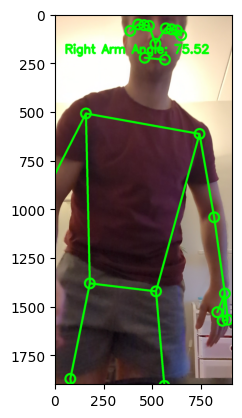

In [5]:
process_video('etc/vidroom1.mp4', options, orientation=3)